<img src="img/TJI_logo_whitebg_440x220.jpg" alt="drawing" style="width: 220px;float: right"/>

# Analysis: What kinds of officers are involved in shootings?
---

## Overview
An examination of the categories of police officers that are disproportionately represented in officer-involved shootings.

## IMPORTANT NOTES
* Simply because one demographic of officer is involved in more shootings does **not** mean they are more dangerous or more prone to escalation. For example, lower-ranking officers are more likely to be out on patrol in general, and thus should show up more often in shootings, even if they are just as good at de-escalation as higher-ranking officers.

## Summary of findings
* Younger officers are a more likely to be involved in shootings.
* Racially, officers in shootings are similar to officers at large.
* Men comprise 88% of the Texas police force, but 97% of the officers involved in shootings
* The fact that there are more women among younger officers makes this statistic even more striking.

## Datasets used:
* `tji/officer-involved-shootings/shot_civilians.csv`
* `tji/auxiliary-datasets/list_of_texas_officers`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)

## [ Setup and load data ]

`FIRST_OFFICER_ONLY` configuration:
* If True, only count the first recorded officer in each civilian shooting event.
* If False, count all officers whose details exist for an incident. This is debatable, since there is clearly inconsistent practice in officer recording. See Data Quirks section for `shot_civilians` [on data.world](https://data.world/tji/officer-involved-shootings/workspace/project-summary)

In [1]:
FIRST_OFFICER_ONLY = True

In [2]:
import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline

%load_ext watermark
%watermark -a 'Everett Wetchler' -g -d -t -z -w -p numpy,pandas,matplotlib,seaborn,datadotworld

Everett Wetchler 2018-05-31 21:02:59 PDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
seaborn 0.7.1
datadotworld 1.6.0
Git hash: 170e84008c7caa8248127f9d41eb369edcf902c3
watermark 1.5.0


Removing 3 past plots


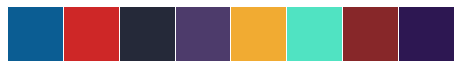

In [3]:
from scipy import stats
from lib.utils import *
from lib.style import *

sns.palplot(sns.color_palette())

plotsaver = PlotSaver('../plots/', 'ois_which_officers_' + ('' if FIRST_OFFICER_ONLY else 'include_all_'),
                      numbering=False)

In [4]:
def long_gender_name(g):
    if pd.isnull(g):
        return g
    return 'MALE' if g.startswith('M') else 'FEMALE'

In [5]:
datasets = dw.load_dataset('tji/officer-involved-shootings', force_update=True)
shot_civ = datasets.dataframes['shot_civilians']
shot_civ.head()

,date_incident,incident_address,incident_city,incident_county,incident_zip,incident_longitude,incident_latitude,incident_census_tract,incident_result_of,incident_call_other,civilian_name_first,civilian_name_last,civilian_name_full,civilian_gender,civilian_age,civilian_race,civilian_died,officer_age_1,officer_race_1,officer_gender_1,agency_name_1,agency_report_date_1,agency_city_1,agency_county_1,agency_zip_1,agency_name_person_filling_out_1,agency_email_person_filling_out_1,officer_age_2,officer_race_2,officer_gender_2,officer_caused_injury_2,agency_name_2,agency_report_date_2,agency_city_2,agency_county_2,agency_zip_2,agency_name_person_filling_out_2,agency_email_person_filling_out_2,officer_age_3,officer_race_3,officer_gender_3,officer_caused_injury_3,agency_name_3,agency_report_date_3,agency_city_3,agency_county_3,agency_zip_3,agency_name_person_filling_out_3,agency_email_person_filling_out_3,officer_age_4,...,agency_name_person_filling_out_7,agency_email_person_filling_out_7,officer_age_8,officer_race_8,officer_gender_8,agency_name_8,agency_report_date_8,agency_city_8,agency_county_8,agency_zip_8,agency_name_person_filling_out_8,agency_email_person_filling_out_8,officer_age_9,officer_race_9,officer_gender_9,agency_name_9,agency_report_date_9,agency_city_9,agency_county_9,agency_zip_9,agency_name_person_filling_out_9,agency_email_person_filling_out_9,officer_age_10,officer_race_10,officer_gender_10,agency_name_10,agency_report_date_10,agency_city_10,agency_county_10,agency_zip_10,agency_name_person_filling_out_10,agency_email_person_filling_out_10,news_coverage_1,news_coverage_2,news_coverage_3,news_coverage_4,cdr_narrative,custodial_death_report,deadly_weapon,deadly_weapon_category,deadly_weapon_description,lea_narrative_published,lea_narrative_shorter,multiple_officers_involved,num_officers_recorded,num_reports_filed,num_rows_about_this_incident,officer_on_duty,time_incident,incident_location
0,2015-09-02,1010 MAGNOLIA STREET,FREEPORT,BRAZORIA,77541.0,-95.356262,28.944891,664400.0,TRAFFIC STOP,NARCOTIC STOP AND EVADING ARREST,RICKEY,MAYBERRY,RICKEY MAYBERRY,M,30.0,BLACK,False,27.0,HISPANIC,M,FREEPORT POLICE DEPT,9/16/2015,FREEPORT,BRAZORIA,77541,PAMELA MORRIS,PMORRIS@FREEPORT.TX.US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,ABC 13,YOUR SOUTHEST TEXAS,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,True,1,1,1,True,NaN,POINT(-95.3562616 28.9448909)
1,2015-09-03,4840 E. PLANO PARKWAY,PLANO,COLLIN,75074.0,-96.642308,33.008128,32010.0,OTHER - SPECIFY TYPE OF CALL,ACCIDENTAL DISCHARGE RICOCHET DURING RANGE ACT...,NaN,NaN,NaN,M,55.0,WHITE,False,30.0,HISPANIC,M,PLANO POLICE DEPT,10/1/2015,PLANO,COLLIN,75074,CURTIS HOWARD,CURTISH@PLANO.GOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,(DETAILS MISSING),NaN,NaN,NaN,False,1,1,1,True,NaN,POINT(-96.6423077 33.0081284)
2,2015-09-04,101 COUCH CT.,SPRINGTOWN,PARKER,76082.0,-97.634194,32.916724,140409.0,OTHER - SPECIFY TYPE OF CALL,INVESTIGATION OF CRIMINAL ACTIVITY,SULLY JOE,LANIER,SULLY JOE LANIER,M,36.0,WHITE,True,27.0,WHITE,M,PARKER CO SHERIFFS OFFICE,10/6/2015,WEATHERFORD,PARKER,76086,MEREDITH GRAY,MEREDITH.GRAY@PARKERCOUNTYTX.COM,56.0,WHITE,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,WFAA,DFW CBS LOCAL,STAR TELEGRAM,FOX 4 NEWS,DECEDENT SHOT A RIFLE AT LE OFFICERS WHOM RETU...,True,True,FIREARM,FIREARM,NaN,FIRED AT OFFICERS,True,2,1,1,True,NaN,POINT(-97.6341935 32.9167242)
3,2015-09-05,4926 CHENNAULT ROAD,HOUSTON,HARRIS,77033.0,-95.344966,29.

In [6]:
before = len(shot_civ)
shot_civ = shot_civ.drop_duplicates(subset=['incident_address', 'date_incident'])
print('Dropped %d rows beyond the first for an incident' % (before - len(shot_civ)))

Dropped 19 rows beyond the first for an incident


In [7]:
ois_officers = shot_civ[['officer_age_1', 'officer_gender_1', 'officer_race_1']]
ois_officers.columns = ['age', 'gender', 'race']
print("Found  %d #1 officers" % len(ois_officers))

if not FIRST_OFFICER_ONLY:
    for i in range(2, 11):
        df = shot_civ[['officer_age_%d' % i, 'officer_gender_%d' % i, 'officer_race_%d' % i]].dropna()
        print("Adding %d #%d officers" % (len(df), i))
        df.columns = ['age', 'gender', 'race']
        ois_officers = pd.concat([ois_officers, df], axis=0)

print(ois_officers.shape)

Found  447 #1 officers
(447, 3)


In [8]:
def get_age_range(age):
    if pd.isnull(age):
        return age
    if age < 31:
        return '21-30'
    elif age < 41:
        return '31-40'
    elif age < 51:
        return '41-50'
    else:
        return '51+'

ois_officers['age_range'] = ois_officers['age'].apply(get_age_range)
ois_officers['gender'] = ois_officers.gender.apply(long_gender_name)
ois_officers.head()

/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,gender,race,age_range
0,27.0,MALE,HISPANIC,21-30
1,30.0,MALE,HISPANIC,21-30
2,27.0,MALE,WHITE,21-30
3,28.0,MALE,WHITE,21-30
4,38.0,MALE,HISPANIC,31-40


In [9]:
ois_officers.gender.value_counts()

MALE      432
FEMALE     15
Name: gender, dtype: int64

In [10]:
dataset = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
all_officers = dataset.dataframes['list_of_texas_officers']

In [11]:
all_officers['age_for_plot'] = all_officers.age_range.apply(lambda r: r if pd.isnull(r) else int(r[:2]))
all_officers['gender'] = all_officers.gender.apply(long_gender_name)
all_officers.head()

,name_full,name_first,name_middle,name_last,name_suffix,gender,race,age_range,current_agency,current_agency_county,highest_cert,highest_cert_int,service_time,age_for_plot
0,DALE E SCHNELLE,DALE,E,SCHNELLE,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 1,ANDERSON,MASTER PEACE OFFICER,4,23.00,51
1,GARY D THOMAS,GARY,D,THOMAS,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 1,ANDERSON,MASTER PEACE OFFICER,4,43.08,51
2,CHARLES D LIGHTFOOT,CHARLES,D,LIGHTFOOT,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 2,ANDERSON,MASTER PEACE OFFICER,4,24.67,51
3,WILLIAM R WATTS,WILLIAM,R,WATTS,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 2,ANDERSON,MASTER PEACE OFFICER,4,23.33,51
4,KIMBERLY S HOLLIDAY,KIMBERLY,S,HOLLIDAY,NaN,FEMALE,WHITE,51+,ANDERSON CO CONST PCT 3,ANDERSON,MASTER PEACE OFFICER,4,17.33,51


## [ Helper code ]

In [12]:
plotsaver = PlotSaver('../plots/', 'ois_which_officers_' + ('' if FIRST_OFFICER_ONLY else 'include_all_'), numbering=True)

Removing 0 past plots


In [13]:
LABEL_OIS = 'Officers in shootings'
LABEL_ALL = 'All Texas officers'

## [ Begin analysis ]

## [ Are officers of certain _ages_ disproportionately involved in shootings? ]

In [14]:
AGE_PLOT_TITLE = 'OIS officer ages'

In [16]:
s1 = all_officers['age_range'].value_counts().sort_index()
s1.name = LABEL_ALL
s2 = ois_officers['age_range'].value_counts().sort_index()
s2.name = LABEL_OIS
df = pd.DataFrame([s1, s2]).T
df.index = ['Ages\n%s' % i for i in df.index]
chi, p = stats.chi2_contingency(df.values)[:2]
print(p, chi)

# AGE_PLOT_TITLE += ' ' + test_summary(p, chi=True)

age_df = df
age_df

1.1357019749262026e-41 193.38081767018775


,All Texas officers,Officers in shootings
Ages\n21-30,11443,148
Ages\n31-40,21793,170
Ages\n41-50,23145,97
Ages\n51+,21280,32


Saving plot to ../plots/ois_which_officers_01_age_donut.png


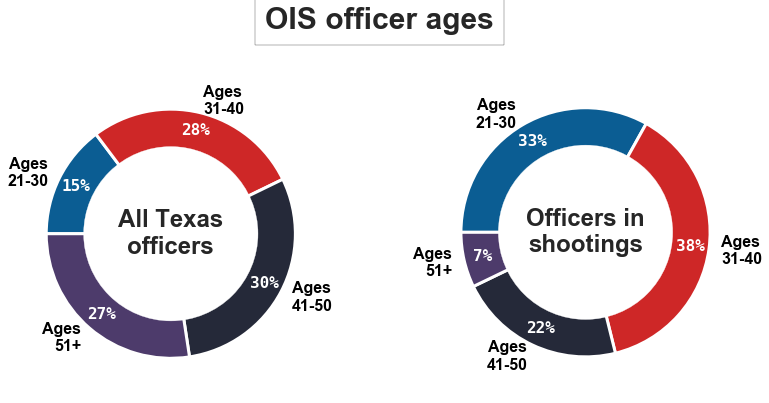

In [16]:
fig, ax = pie_plot(age_df, donut=True, title=AGE_PLOT_TITLE)
plotsaver.saveplot(fig, 'age_donut', dpi=300)

## [ Are officers of certain _genders_ disproportionately involved in shootings? ]

In [17]:
GENDER_PLOT_TITLE = 'OIS officer genders'

In [18]:
s1 = all_officers.gender.value_counts()
s1.name = LABEL_ALL
s2 = ois_officers.gender.value_counts()
s2.name = LABEL_OIS
df = pd.concat([s1, s2], axis=1)
p = stats.chi2_contingency(df.values)[1]
print(p)

# GENDER_PLOT_TITLE += ' ' + test_summary(p, chi=True)

gender_df = df
gender_df

1.3940649500334718e-08


,All Texas officers,Officers in shootings
MALE,68078,432
FEMALE,9538,15


Saving plot to ../plots/ois_which_officers_02_gender_donut.png


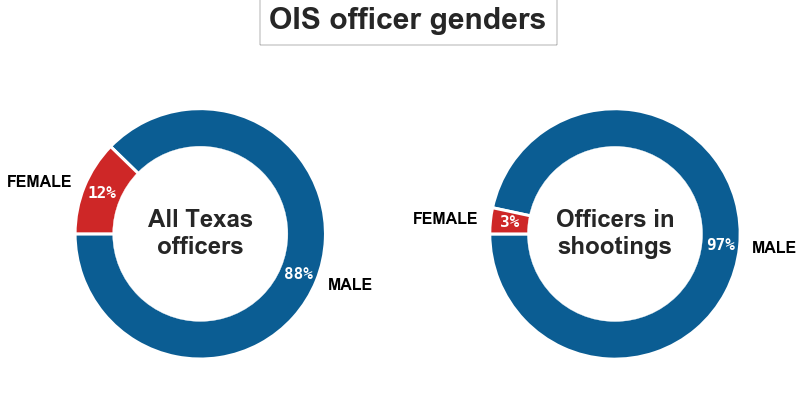

In [19]:
fig, ax = pie_plot(gender_df, donut=True, counterclock=True, title=GENDER_PLOT_TITLE)
plotsaver.saveplot(fig, 'gender_donut', dpi=300)

## [ Are officers of certain _races_ disproportionately involved in shootings? ]

In [20]:
RACE_PLOT_TITLE = 'OIS officer races'

In [22]:
s1 = all_officers.race.value_counts().sort_index()
s1.name = LABEL_ALL
s2 = ois_officers.race.value_counts().sort_index()
s2.name = LABEL_OIS
race_df = pd.DataFrame([s1, s2]).T
chi, p = stats.chi2_contingency(race_df.values)[:2]
print(chi, p)

# RACE_PLOT_TITLE += test_summary(p, chi=True)

print(p)
race_df

9.60675906322987 0.02222232982931067
0.02222232982931067


,All Texas officers,Officers in shootings
BLACK,7908,34
HISPANIC,21987,130
OTHER,1883,3
WHITE,45883,280


Saving plot to ../plots/ois_which_officers_03_race_donut.png


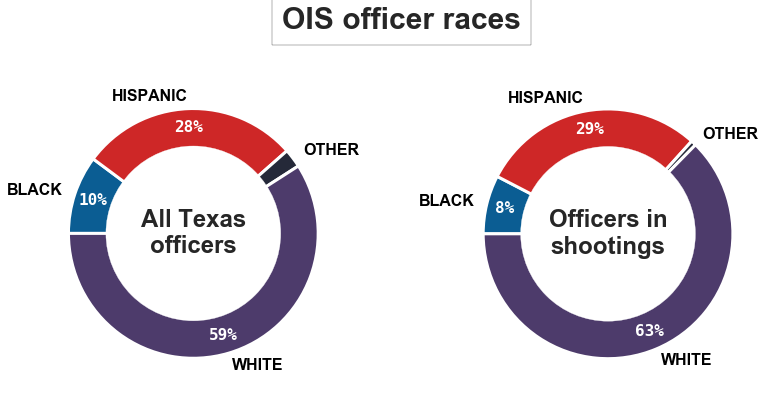

In [23]:
fig, ax = pie_plot(race_df, donut=True, title=RACE_PLOT_TITLE)
plotsaver.saveplot(fig, 'race_donut', dpi=300)